In [110]:
#!pip install botorch
#!pip install pyDOE
#!pip install openpyxl
#!pip install smt
#!pip install scikit-optimize

In [111]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs



In [112]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.acquisition.objective import PosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import LogProbabilityOfImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
#from botorch.transforms import Standardize
#from botorch.utils.transforms import euclidean_distance



In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


#Generate points

#import data

# Inputs

check the sampling file

# Outputs

In [125]:
#%run /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract
from PNNL_spectra_extract import data_102119
data_102119.head(16)[['time','temp','analyte','yield product']]
#/Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract

0.009902666666666666

In [129]:
avg_data = data_102119.groupby('time').mean().reset_index()[['time','temp','sulf','analyte','yield product']]
avg_data

,time,temp,sulf,analyte,yield product
0,49,45.0,89.0,84.0,0.009903
1,87,95.0,95.0,97.0,0.103900
2,125,95.0,80.0,39.0,0.033182
3,163,145.0,90.0,57.0,0.777693
4,201,145.0,75.0,79.0,0.025126
5,239,95.0,82.0,62.0,0.027045
6,277,45.0,77.0,93.0,0.015058
7,315,95.0,92.0,75.0,0.303520
8,353,145.0,94.0,66.0,0.972973
9,391,145.0,97.0,35.0,0.974877


# Start of BO

In [130]:
# Modify the objective function to minimize the L2 distance between the predicted and reference RGB values
def quary(predicted_composition,pool_y,pool_x):
    vector_y = []
    vector_x = []
    id = []
    # Reference RGB value (the desired or ideal RGB you want to achieve)
    #desired_composition = torch.tensor([58.61125 , 123.11375 ,  83.640625],dtype=dtype)
    # Calculate the Euclidean distance between measured and desired compositions
    #distance_ref = desired_composition - predicted_composition #d2 = cand-reference

    for i in range(len(predicted_composition)):
        pool_distance = torch.norm(predicted_composition[i]-pool_x,dim=1)

        vector_y.append(pool_y[pool_distance.argmin()])
        vector_x.append(pool_x[pool_distance.argmin()])

        indices_to_remove = pool_distance.argmin()
        # Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
        mask = torch.ones(pool_x.size(0), dtype=torch.bool)
        mask[indices_to_remove] = 0

        # Use the mask to select elements from the tensor
        pool_y = pool_y[mask]
        pool_x = pool_x[mask]

        #id.append(torch.norm(pool_distance,dim=1).argmin().item())

    vector_y = np.array([element for element in vector_y])
    vector_x = np.array([element for element in vector_x])
    #d_pool =  torch.abs(pool_y - predicted_composition).mean(axis=1)
    #actual = actual_pool[distance]
    #candidate = actual_candidates[distance]
    return torch.tensor(vector_y),torch.tensor(vector_x),pool_y, pool_x 


In [131]:
#Setting up the data
#reference = torch.tensor([58.61125 , 123.11375 ,  83.640625],dtype=torch.float32) ##??
# x = torch.tensor([data_102119['time'],data_102119['temp'],data_102119['sulf'],data_102119['analyte']],dtype=torch.float32).T#[:48]
# y = torch.tensor(data_102119['yield product'],dtype=torch.float32).reshape(-1,1)

x = torch.tensor([avg_data['time'],avg_data['temp'],avg_data['sulf'],avg_data['analyte']],dtype=torch.float32).T#[:48]
y = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)


In [132]:
# np.random.seed(10)
# x_try = x[np.random.choice(y.shape[0], 5, replace=False)]
# quary(x_try,y,x)[0], quary(torch.rand(8,4),y,x)[2].shape

#BO

Reference: https://gist.github.com/danhphan/af53fb7958a28c2e2d514221ea83bd9c

In [133]:
def scalarization_posterior_transform(posterior, target_vector):
    mean = posterior.mean
    # Euclidean distance from the mean to a target as an example scalarization
    scalarized_mean = torch.norm(mean - target_vector, dim=1)
    # Simplified approach: use the maximum variance as the scalarized variance
    scalarized_variance = posterior.variance.max(dim=1).values
    return scalarized_mean,scalarized_variance


class ScalarizedExpectedImprovement(AcquisitionFunction):
    def __init__(self, model, best_f, target_vector):
        super().__init__(model)
        self.best_f = best_f
        self.target_vector = target_vector

    def forward(self, X):
        posterior = self.model.posterior(X)
        # Apply the scalarization transform
        transformed_posterior = scalarization_posterior_transform(posterior, self.target_vector)
        mean = transformed_posterior[0]#.mean
        variance = transformed_posterior[1]#.variance
        sigma = variance.sqrt()
        u = (self.best_f - mean) / sigma
        normal = torch.distributions.Normal(torch.zeros_like(u), torch.ones_like(u))
        ei = sigma * (u * normal.cdf(u) + normal.log_prob(u).exp())
        return ei

class ScalarizedUpperConfidenceBound(AcquisitionFunction):
    def __init__(self, model, kappa, target_vector):
        super().__init__(model)
        self.kappa = kappa
        self.target_vector = target_vector

    def forward(self, X):
        posterior = self.model.posterior(X)
        # Apply the scalarization transform
        transformed_posterior = scalarization_posterior_transform(posterior, self.target_vector)
        mean = transformed_posterior[0]#.mean
        variance = transformed_posterior[1]#.variance
        sigma = variance.sqrt()

        ucb = mean + self.kappa * sigma
        return ucb


#Bayesian Optimization

https://distill.pub/2020/bayesian-optimization/

https://github.com/pytorch/botorch/issues/546

In [134]:
train_size = 3

rand_id = []
for n in range(20):
    np.random.seed(n)
    random_id = np.random.choice(y.shape[0], size=train_size, replace=False)
    rand_id.append(random_id)

test_x = torch.tensor(x[rand_id[0]], dtype=dtype).to(device=device, dtype=dtype)
test_y = torch.tensor(y[rand_id[0]], dtype=dtype)

test_x, test_y,rand_id[0]

(tensor([[ 87.,  95.,  95.,  97.],
         [277.,  45.,  77.,  93.],
         [353., 145.,  94.,  66.]]),
 tensor([[0.1039],
         [0.0151],
         [0.9730]]),
 array([1, 6, 8]))

In [135]:
abs(y).T.sort()

torch.return_types.sort(
values=tensor([[0.0099, 0.0143, 0.0151, 0.0225, 0.0251, 0.0270, 0.0313, 0.0332, 0.1039,
         0.1650, 0.2077, 0.3035, 0.7777, 0.9730, 0.9749]]),
indices=tensor([[ 0, 11,  6, 10,  4,  5, 12,  2,  1, 14, 13,  7,  3,  8,  9]]))

In [138]:
bounds = torch.tensor([[0., 0., 0.,0.], [600., 145., 100.,100.]], dtype=dtype, device=device)
batch_size = 1 #train_size

iteration_number=(len(avg_data)-train_size)//batch_size
iterations = list(range(0, iteration_number+1))#list(range(1, iteration_number+1))

# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
target_vector = torch.tensor([1],dtype=dtype) # target is 95% or highers
iteration_number

12

In [139]:
iterations = list(range(1, iteration_number+1))
len(iterations)

12

In [167]:
def prediction(cand_eval,model):
    with torch.no_grad():
        posterior = model.posterior(cand_eval)
        mean = posterior.mean
        variance = posterior.variance
        return mean,variance

def BO_loop(acq_func_id,train_size,batch_size,random_id,y,x,iteration_number):
    train_x = torch.tensor(x[random_id], dtype=dtype).to(device=device, dtype=dtype)
    train_y = torch.tensor(y[random_id], dtype=dtype)

    indices_to_remove = random_id 
    # Create a mask where 1 indicates indices to keep and 0 indicates indices to remove
    mask = torch.ones(y.size(0), dtype=torch.bool)
    mask[indices_to_remove] = 0
    y_pool = y[mask] #93 exclude training data
    x_pool = x[mask] #93 exclude training data

    gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

   
    frames_y = [train_y.cpu().numpy()]
    frames_x = [train_x.cpu().numpy()]
    #best_y = train_y[torch.norm(train_y-target_vector,dim=1).argmax()].cpu().detach()
    best_y = train_y[abs(train_y-target_vector).argmax()].cpu().detach()
    best_y_values=[best_y]
    
    #acq_funcs = [ScalarizedExpectedImprovement(gp_model, best_f=best_f, target_vector=target_vector),ScalarizedUpperConfidenceBound(gp_model,kappa=2.0,target_vector=target_vector)]
    acq_funcs = [ExpectedImprovement(model=gp_model, best_f=best_y),qExpectedImprovement(model=gp_model, best_f=best_y ),UpperConfidenceBound(model=gp_model, beta=1),PosteriorMean(model=gp_model),ProbabilityOfImprovement(model=gp_model, best_f=best_y)]


    iteration = 0
    count_min = 0

    #true_min_y = y[torch.norm(y-reference,dim=1).argmin()].numpy()
    end_count = -1

    
    goal = []
    while iteration < iteration_number :
        #distance_min = np.linalg.norm(best_y  - target_vector)
        #if np.linalg.norm(best_y  - true_min_y) == 0.0 and count_min == 0:
        #if distance_min <= 0.025 and count_min == 0:
        if best_y > 0.95 and count_min !=1:
            end_count = iteration
            #count_min += 1
            best_y_values = np.array([element for element in best_y_values]) 
            print("Final Iteration: "+str(end_count))
            return best_y_values, train_y, train_x, end_count,goal #,distance      
        #print("Iteration: "+str(iteration))
        # elif  train_y[torch.norm(train_x-frames_x[iteration],dim=1).argmin()] > 0.95 and count_min <= 3:
        #     count_min += 1
        #     goal.append(x_pool[torch.norm(train_x-candidate,dim=1).argmin()])
        else:
            candidate, _ = optimize_acqf(
                acq_function=acq_funcs[acq_func_id],
                bounds=bounds,
                q=batch_size,
                num_restarts=train_size,
                raw_samples=100,
                options={"dtype": dtype, "device": device}
            )

            new_val = quary(candidate,y_pool,x_pool) #torch.tensor(objective(candidate), dtype=torch.float32).reshape(len(objective(candidate)),1)
            new_x = new_val[1]
            new_y = new_val[0]

            train_x = torch.cat([train_x,  new_x ]) 
            train_y = torch.cat([train_y,  new_y ])

            y_pool = new_val[2]
            x_pool = new_val[3]

            gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
            mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
            fit_gpytorch_model(mll)

            best_y = train_y[torch.norm(train_y-target_vector,dim=1).argmin()].cpu().detach()
            #distance_min = np.linalg.norm(best_y  - target_vector)
            best_y_values.append(best_y)
            #best_y_values.append(train_y[train_y.mean(dim=1).argmin()].cpu().detach().numpy())
            frames_y.append(new_val[0].cpu().detach().numpy())
            frames_x.append(new_val[1].cpu().detach().numpy())
            #distance.append(distance_min)

            iteration +=1
    
    best_y_values = np.array([element for element in best_y_values])  
    print("Final Iteration: "+str(end_count))    
    return best_y_values, train_y, train_x, end_count,goal#,distance


#best_point = train_x[train_y.argmin(), :]
#best_value = train_y.min().item()


In [179]:
num = 3
ExpImp = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
qExpImp = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
UppCB = BO_loop(acq_func_id=2,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
PostMean = BO_loop(acq_func_id=3,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)
ProbImp = BO_loop(acq_func_id=4,train_size=train_size,batch_size = batch_size,random_id = rand_id[num],y = y,x = x,iteration_number = iteration_number)

# ExpImp_8 = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id = rand_id[19],y = y,x = x,iteration_number = iteration_number)
# UppCB_8 = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id = rand_id[19],y = y,x = x,iteration_number = iteration_number)

# ExpImp_32 = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id=rand_id[3],y = y,x = x,iteration_number = iteration_number)
# UppCB_32 = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id=rand_id[3],y = y,x = x,iteration_number = iteration_number)



Final Iteration: 4
Final Iteration: 1
Final Iteration: 10
Final Iteration: 9
Final Iteration: 3


In [169]:
#ExpImp[5],qExpImp[5],UppCB[5],PostMean[5],ProbImp[5]

Text(0.5, 1.0, 'Train Y')

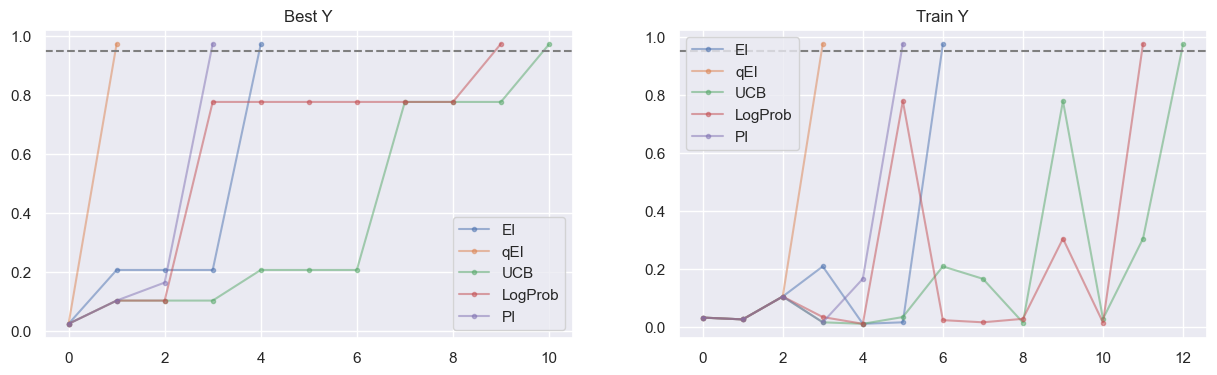

In [181]:
alpha = 0.5
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(ExpImp[0],'.-',alpha =alpha )
plt.plot(qExpImp[0],'.-',alpha =alpha)
plt.plot(UppCB[0],'.-',alpha =alpha)
plt.plot(PostMean[0],'.-',alpha =alpha)
plt.plot(ProbImp[0],'.-',alpha =alpha)
plt.axhline(0.95,linestyle = '--',color = 'tab:grey')
plt.legend(['EI', 'qEI','UCB','LogProb','PI'])
plt.title('Best Y')

plt.subplot(1,2,2)
plt.plot(ExpImp[1],'.-',alpha =alpha)
plt.plot(qExpImp[1],'.-',alpha =alpha)
plt.plot(UppCB[1],'.-',alpha =alpha)
plt.plot(PostMean[1],'.-',alpha =alpha)
plt.plot(ProbImp[1],'.-',alpha =alpha)
plt.axhline(0.95,linestyle = '--',color = 'tab:grey')
plt.legend(['EI', 'qEI','UCB','LogProb','PI'])
plt.title('Train Y')



Text(0.5, 1.0, 'Train X')

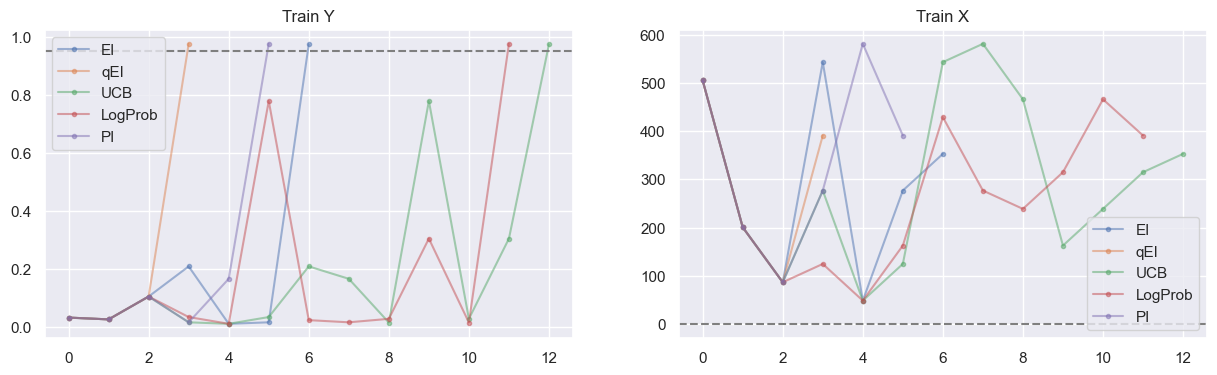

In [182]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.plot(ExpImp[1],'.-',alpha =alpha )
plt.plot(qExpImp[1],'.-',alpha =alpha)
plt.plot(UppCB[1],'.-',alpha =alpha)
plt.plot(PostMean[1],'.-',alpha =alpha)
plt.plot(ProbImp[1],'.-',alpha =alpha)
plt.axhline(0.95,linestyle = '--',color = 'tab:grey')
plt.legend(['EI', 'qEI','UCB','LogProb','PI'])
plt.title('Train Y')

plt.subplot(1,2,2)
plt.plot(ExpImp[2][:,0],'.-',alpha =alpha)
plt.plot(qExpImp[2][:,0],'.-',alpha =alpha)
plt.plot(UppCB[2][:,0],'.-',alpha =alpha)
plt.plot(PostMean[2][:,0],'.-',alpha =alpha)
plt.plot(ProbImp[2][:,0],'.-',alpha =alpha)
plt.axhline(0.95,linestyle = '--',color = 'tab:grey')
plt.legend(['EI', 'qEI','UCB','LogProb','PI'])
plt.title('Train X')

# plots

In [81]:
def min_sort(arary):
    min_val = arary[0]
    for i in range(arary.shape[0]):
        if arary[i]<= min_val:    
            min_val = arary[i]
        else:
            arary[i] = min_val
    return arary

def max_sort(arary):
    min_val = arary[0]
    for i in range(arary.shape[0]):
        if arary[i]>= min_val:    
            min_val = arary[i]
        else:
            arary[i] = min_val
    return arary

In [82]:
# true_min_y = y[torch.norm(y-reference,dim=1).argmin()].numpy()
# true_min_x = x[torch.norm(y-reference,dim=1).argmin()].numpy()

# print('best id =',torch.norm(y-reference,dim=1).argmin().item())
# print('reference = ',reference)
# print('true x : ',true_min_x)
# print('true y : ',true_min_y)

In [144]:
best_y_EI = ExpImp[0]
frames_EI = ExpImp[1]
candidate_EI =ExpImp[2]
trainy_EI = ExpImp[3]
EI_end = ExpImp[4]

# best_y_UCB = UppCB[0]
# frames_UCB = UppCB[1]
# candidate_UCB = UppCB[2]
# trainy_UCB = UppCB[3]
# UCB_end = UppCB[4]

# best_y_EI = ExpImp_32[0]
# best_y_UCB = UppCB_32[0]
# frames_EI = ExpImp_32[1]
# frames_UCB = UppCB_32[1]
# candidate_EI =ExpImp_32[2]
# candidate_UCB = UppCB_32[2]
# trainy_EI = ExpImp_32[3]
# trainy_UCB = UppCB_32[3]
# EI_end = ExpImp_32[4]
# UCB_end = UppCB_32[4]


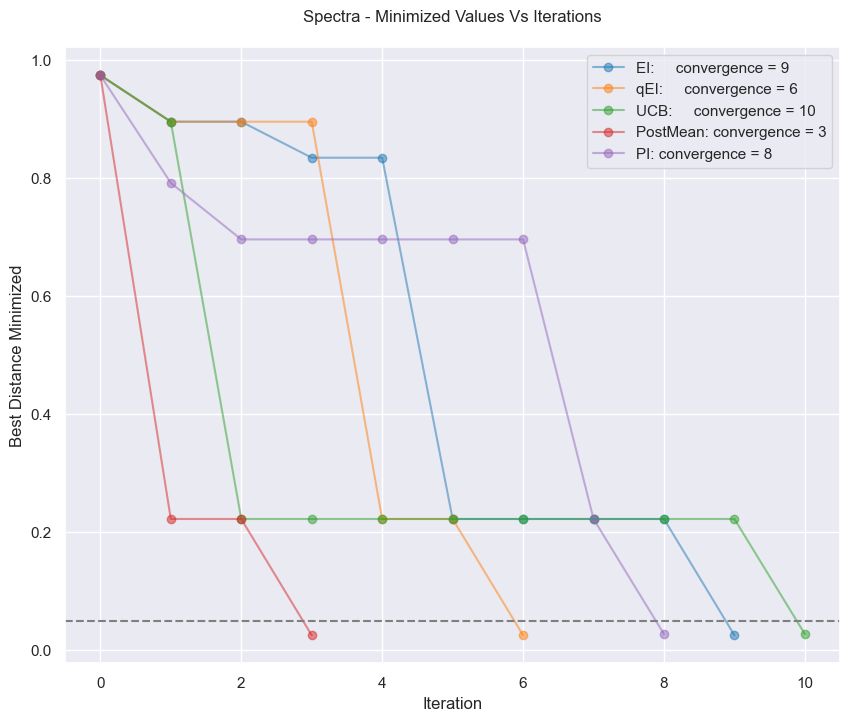

In [145]:
alpha=0.5
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,ExpImp[4]+1,1),   abs(ExpImp[0]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:blue')
plt.plot(np.arange(0,qExpImp[4]+1,1), abs(qExpImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:orange')
plt.plot(np.arange(0,UppCB[4]+1,1),abs(UppCB[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:green')
plt.plot(np.arange(0,PostMean[4]+1,1),abs(PostMean[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:red')
plt.plot(np.arange(0,ProbImp[4]+1,1),abs(ProbImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:purple')
plt.axhline(abs(0.95-best_f),linestyle = '--',color = 'tab:grey')

# plt.plot(np.arange(0,43,1),   abs(ExpImp[0]- best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:blue')
# plt.plot(np.arange(0,43,1), abs(qExpImp[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:cyan')
# plt.plot(np.arange(0,43,1),abs(UppCB[0]-best_f.numpy()), marker='o', linestyle='-', alpha=alpha,color='tab:purple')


# plt.plot(iterations,best_y_values[1] , marker='o', linestyle='-', color='r')
# plt.plot(iterations,best_y_values[2] , marker='o', linestyle='-', color='g')
#plt.errorbar(iterations, np.mean(supra_best,axis=0),yerr=np.std(supra_best,axis=0))
plt.title('Spectra - Minimized Values Vs Iterations\n')
plt.xlabel('Iteration')
plt.ylabel('Best Distance Minimized')
plt.grid(True)
plt.legend(['EI:     convergence = %s'%ExpImp[4],
            'qEI:     convergence = %s'%qExpImp[4],
            'UCB:     convergence = %s'%UppCB[4], 
            'PostMean: convergence = %s'%PostMean[4],
            'PI: convergence = %s'%ProbImp[4]])


In [147]:
#frames_EI[0][np.linalg.norm(frames_EI[0]-reference_rgb.numpy(),axis=1).argmin()]
frame_y_EI = frames_EI[0]
# frame_y_UCB = frames_UCB[0]
candi_EI = candidate_EI[0]
# candi_UCB = candidate_UCB[0]
for i in range(len(frames_EI)-1):
    frame_y_EI = np.vstack([frame_y_EI,frames_EI[i+1]])
    candi_EI = np.vstack([candi_EI,candidate_EI[i+1]])
# for i in range(len(frames_UCB)-1):
#     frame_y_UCB = np.vstack([frame_y_UCB,frames_UCB[i+1]])
#     candi_UCB = np.vstack([candi_UCB,candidate_UCB[i+1]])
frame_y_EI.reshape(1,-1)
candi_EI.reshape(1,-1)

array([[505.,  45.,  99.,  53., 201., 145.,  75.,  79.,  87.,  95.,  95.,
         97.,  49.,  45.,  89.,  84., 125.,  95.,  80.,  39., 581.,  95.,
         87.,  44., 466.,  45.,  85.,  70., 163., 145.,  90.,  57., 239.,
         95.,  82.,  62., 277.,  45.,  77.,  93., 315.,  95.,  92.,  75.,
        391., 145.,  97.,  35.]], dtype=float32)

In [148]:
i=2
frame_y_EI[i*batch_size:i*batch_size+batch_size].min()
frame_y_EI[i*batch_size:i*batch_size+batch_size][:,0].min()

0.10390038

# Benchmarking

In [149]:
count_EI = np.zeros(len(rand_id))
for i in range(len(rand_id)):
   count_EI[i] = BO_loop(acq_func_id=0,train_size=train_size,batch_size = batch_size,random_id = rand_id[i],y = y,x = x,iteration_number = iteration_number)[4]
count_EI

Final Iteration: 1
Final Iteration: 4
Final Iteration: 7
Final Iteration: 8
Final Iteration: 8
Final Iteration: 10
Final Iteration: 1
Final Iteration: 1
Final Iteration: 9
Final Iteration: 2
Final Iteration: 4
Final Iteration: 1
Final Iteration: 1
Final Iteration: 6
Final Iteration: 8
Final Iteration: 1
Final Iteration: 8
Final Iteration: 8
Final Iteration: 5
Final Iteration: 1


array([ 1.,  4.,  7.,  8.,  8., 10.,  1.,  1.,  9.,  2.,  4.,  1.,  1.,
        6.,  8.,  1.,  8.,  8.,  5.,  1.])

In [150]:
count_qEI = np.zeros(len(rand_id))
for i in range(len(rand_id)):
   count_qEI [i] = BO_loop(acq_func_id=1,train_size=train_size,batch_size = batch_size,random_id = rand_id[i],y = y,x = x,iteration_number = iteration_number)[4]
count_qEI 

Final Iteration: 1
Final Iteration: 7
Final Iteration: 6
Final Iteration: 11
Final Iteration: 8
Final Iteration: 3
Final Iteration: 2
Final Iteration: 1
Final Iteration: 7
Final Iteration: 5
Final Iteration: 11
Final Iteration: 1
Final Iteration: 1
Final Iteration: 8
Final Iteration: 2
Final Iteration: 1
Final Iteration: 4
Final Iteration: 2
Final Iteration: 3
Final Iteration: 1


array([ 1.,  7.,  6., 11.,  8.,  3.,  2.,  1.,  7.,  5., 11.,  1.,  1.,
        8.,  2.,  1.,  4.,  2.,  3.,  1.])

In [151]:
count_UCB = np.zeros(len(rand_id))
for i in range(len(rand_id)):
   count_UCB[i] = BO_loop(acq_func_id=2,train_size=train_size,batch_size = batch_size,random_id = rand_id[i],y = y,x = x,iteration_number = iteration_number)[4]


Final Iteration: 1
Final Iteration: 2
Final Iteration: 7
Final Iteration: 10
Final Iteration: 1
Final Iteration: 7
Final Iteration: 5
Final Iteration: 1
Final Iteration: 2
Final Iteration: 6
Final Iteration: 2
Final Iteration: 1
Final Iteration: 1
Final Iteration: 11
Final Iteration: 9
Final Iteration: 1
Final Iteration: 10
Final Iteration: 11
Final Iteration: 10
Final Iteration: 1


In [152]:
count_PM = np.zeros(len(rand_id))
for i in range(len(rand_id)):
   count_PM[i] = BO_loop(acq_func_id=3,train_size=train_size,batch_size = batch_size,random_id = rand_id[i],y = y,x = x,iteration_number = iteration_number)[4]


Final Iteration: 1
Final Iteration: 6
Final Iteration: 9
Final Iteration: 8
Final Iteration: 9
Final Iteration: 3
Final Iteration: 9
Final Iteration: 1
Final Iteration: 9
Final Iteration: 7
Final Iteration: 2
Final Iteration: 1
Final Iteration: 1
Final Iteration: 6
Final Iteration: 4
Final Iteration: 1
Final Iteration: 1
Final Iteration: 5
Final Iteration: 6
Final Iteration: 1


In [153]:
count_PI = np.zeros(len(rand_id))
for i in range(len(rand_id)):
   count_PI[i] = BO_loop(acq_func_id=4,train_size=train_size,batch_size = batch_size,random_id = rand_id[i],y = y,x = x,iteration_number = iteration_number)[4]

Final Iteration: 1
Final Iteration: 4
Final Iteration: 10
Final Iteration: 3
Final Iteration: 5
Final Iteration: 2
Final Iteration: 2
Final Iteration: 1
Final Iteration: 6
Final Iteration: 7
Final Iteration: 2
Final Iteration: 1
Final Iteration: 1
Final Iteration: 10
Final Iteration: 7
Final Iteration: 1
Final Iteration: 7
Final Iteration: 9
Final Iteration: 9
Final Iteration: 1


In [154]:
count_EI.mean(),count_UCB.mean()

(4.7, 4.95)

In [155]:
# # plt.plot(count_EI,'.-')
# # plt.plot(count_UCB,'.-')
# bin_com = np.ones(len(count_EI))
# for i in range(count_EI.shape[0]):
#     if count_EI[i] == count_UCB[i]:
#         bin_com[i] = 0 
#     elif count_EI[i] < count_UCB[i]:
#         bin_com[i] = -1
#     else: 
#         bin_com[i] =1

# plt.bar(np.arange(0,len(count_EI),1),count_EI)
# plt.bar(np.arange(0,len(count_EI),1),-count_UCB)


[None, None]

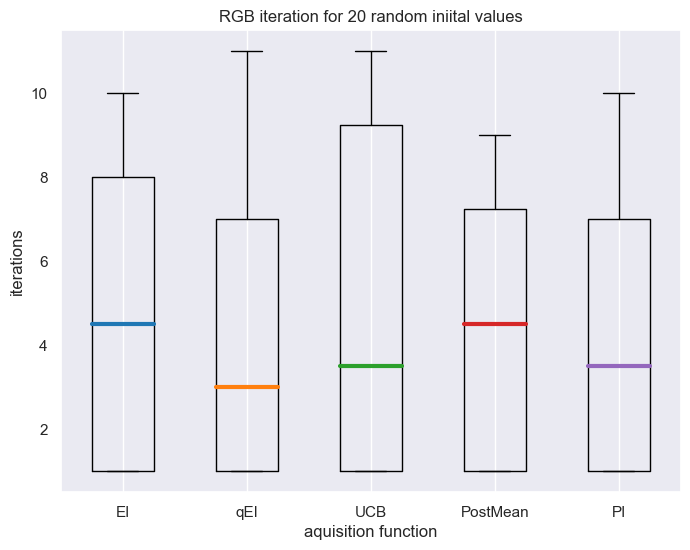

In [156]:
#plt.boxplot([count_EI,count_UCB],labels=['EI','UCB'],)

all_data = [count_EI,count_qEI,count_UCB,count_PM,count_PI]
labels = ['EI','qEI','UCB','PostMean','PI']

fig = plt.figure(figsize=(8, 6))

# rectangular box plot
bplot1 = plt.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         labels=labels)  # will be used to label x-ticks
plt.title('RGB iteration for 20 random iniital values')
plt.ylabel('iterations')
plt.xlabel('aquisition function')
plt.grid(axis='y') 


bplot1['medians'][0].set(color = 'tab:blue' ,linewidth = 3)
bplot1['medians'][1].set(color = 'tab:orange' ,linewidth = 3)
bplot1['medians'][2].set(color = 'tab:green' ,linewidth = 3)
bplot1['medians'][3].set(color = 'tab:red' ,linewidth = 3)
bplot1['medians'][4].set(color = 'tab:purple' ,linewidth = 3)